# Radial Beam Sampling

In [28]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

### Load the dataset

In [29]:
dataset_name = 'coil100'
dataset = tfds.load(dataset_name, split='train', shuffle_files=True)

### Specify Beam Paramters

In [30]:
image_size = 128

margin_padding = math.ceil(image_size * (math.sqrt(2) - 1))

# beam length (D)
target_size = (image_size + margin_padding) // 2

# number of beams (|B|)
beam_set_size = 32

# zero padding (delta)
margin_padding = math.ceil(target_size * (math.sqrt(2) - 1))

# image size (W,H)
img_size = int(dataset.element_spec['image'].shape[0])

# new image size (W+delta, H+delta)
w_dim = img_size + margin_padding
h_dim = img_size + margin_padding

# center (start of beams) (c)
center = (w_dim // 2, h_dim // 2)

### Compute Endpoints of Beams
By iterating along all four edges and collect endpoints.

8 Upper Endpoints.
8 Right Endpoints.
8 Lower Endpoints.
8 Left Endpoints.


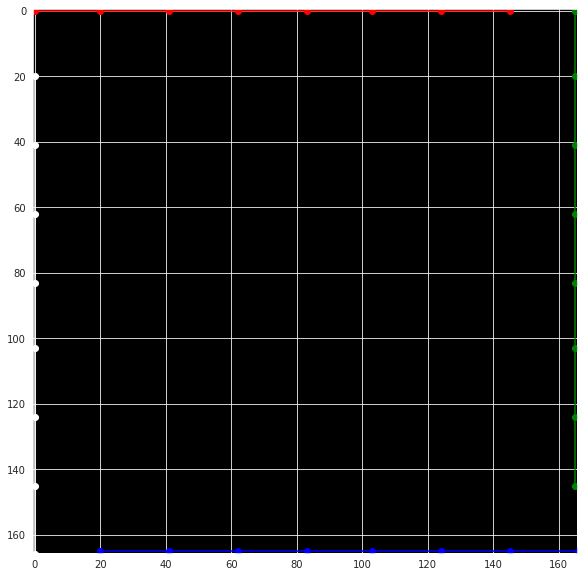

In [31]:
beams_per_quarter = (beam_set_size + 4) // 4

w_atom = w_dim / (beams_per_quarter - 1)
h_atom = h_dim / (beams_per_quarter - 1)

plt.figure(figsize=(10, 10))
endpoint_image = np.zeros((w_dim, h_dim, 3), dtype=np.uint8)

# upper border (left to right)
upper_endpoints = np.array([(int(i * w_atom), 0) for i in range(beams_per_quarter - 1)]) #+ [(w_dim - 1, 0)]
plt.plot(upper_endpoints[:, 0], upper_endpoints[:, 1], marker='o', color="red")
print('{} Upper Endpoints.'.format(len(upper_endpoints)))

# right border (top to bottom)
right_endpoints = np.array([(w_dim - 1, int(i * h_atom)) for i in range(0, beams_per_quarter - 1)])
plt.plot(right_endpoints[:, 0], right_endpoints[:, 1], marker='o', color="green")
print('{} Right Endpoints.'.format(len(right_endpoints)))

# lower border (right to left)
lower_endpoints = np.array([(int(i * w_atom), h_dim - 1) for i in range(beams_per_quarter - 1, 0, -1)])
plt.plot(lower_endpoints[:, 0], lower_endpoints[:, 1], marker='o', color="blue")
print('{} Lower Endpoints.'.format(len(lower_endpoints)))

# left border (bottom to top)
left_endpoints = np.array([(0, int(i * h_atom)) for i in range(beams_per_quarter - 1, 0, -1)])
plt.plot(left_endpoints[:, 0], left_endpoints[:, 1], marker='o', color="white")
print('{} Left Endpoints.'.format(len(left_endpoints)))

plt.imshow(endpoint_image)
plt.grid(True)
plt.show()

endpoints = np.concatenate([upper_endpoints, right_endpoints, lower_endpoints, left_endpoints], axis=0)

### Compute resulting angles/directions of beams

In [32]:
# atan2
def angle_between(p1, p2, degree=False, gpu=False):
    if gpu:
        ang1 = tf.math.atan2(*p1[::-1])
        ang2 = tf.math.atan2(*p2[::-1])
    else:
        ang1 = np.arctan2(*p1[::-1])
        ang2 = np.arctan2(*p2[::-1])
    angle = (ang1 - ang2) % (2 * np.pi)
    if degree:
        return np.rad2deg(angle)
    return angle

angles = [0., ]

# compute vector pointing from center to endpoint
# by translating the image to the center as the new coordinate origin
_endpoints = copy.deepcopy(endpoints)
for i in range(len(_endpoints)):
    _endpoints[i][0] -= center[0]
    _endpoints[i][1] = center[1] - _endpoints[i][1]

# compute the angle between two beams 
for i in range(len(_endpoints) - 1):
    relative_angle = angle_between(_endpoints[i], _endpoints[i+1], degree=True)
    angles.append(angles[-1] + relative_angle)

### Bresenham to estimate pixel positions

In [33]:
def bresenham(start, end, length=None):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points, left, right = [], [], []
    for x in range(x1, x2 + 1):
        coord = [y, x] if is_steep else [x, y]
        points.append(coord)
        proxy_a = [coord[0] - 1, coord[1]] if is_steep else [coord[0], coord[1] - 1]
        proxy_b = [coord[0] + 1, coord[1]] if is_steep else [coord[0], coord[1] + 1]
        if swapped or is_steep:
            left.append(proxy_b)
            right.append(proxy_a)
        # elif not swapped and is_steep:
        #     left.append(proxy_b)
        #     right.append(proxy_a)
        else:
            left.append(proxy_a)
            right.append(proxy_b)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
        left.reverse()
        right.reverse()
    if length is not None:
        return np.array(left)[:length], np.array(points)[:length], np.array(right)[:length]
    return np.array(left), np.array(points), np.array(right)

(32, 3, 83, 2)


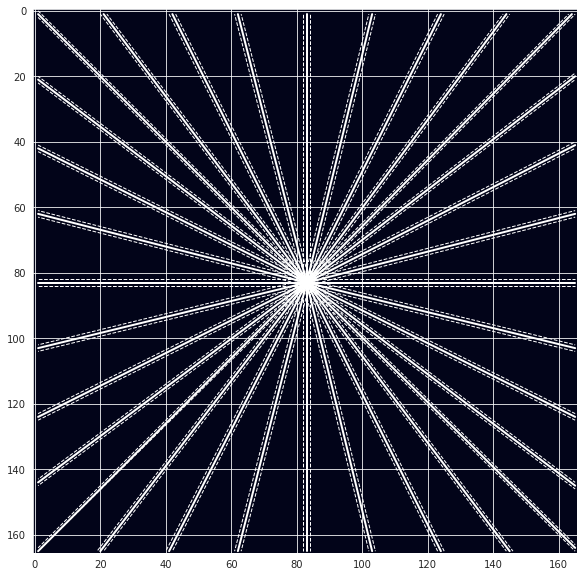

In [34]:
lines = [bresenham(center, endpoint, length=target_size) for endpoint in endpoints]

# clip by shortest beam
shortest_length = np.min([len(point_set) for line in lines for point_set in line])
lines = tf.cast([[point_set[:shortest_length] for point_set in line] for line in lines], tf.int32)
lines = tf.clip_by_value(lines, 0, w_dim - 1)
print(lines.shape)

image = np.zeros((w_dim, h_dim, 1))
fig = plt.figure(figsize=(10, 10))
for line in lines:
    plt.plot([line[1, 0, 0], line[1, -1, 0]], [line[1, 0, 1], line[1, -1, 1]],
            color="white", linewidth=2)
    plt.plot([line[0, 0, 0], line[0, -1, 0]], [line[0, 0, 1], line[0, -1, 1]],
            color="white", linewidth=1, linestyle='dashed')
    plt.plot([line[2, 0, 0], line[2, -1, 0]], [line[2, 0, 1], line[2, -1, 1]],
            color="white", linewidth=1, linestyle='dashed')
plt.imshow(image)

### sample radial beams from images in dataset

In [35]:
# add padding
dataset = dataset.map(lambda x: {'image': tf.pad(x['image'], [
    [tf.math.maximum(0, int((h_dim - x['image'].shape[1]) // 2)),
     tf.math.maximum(0, int((h_dim - x['image'].shape[1]) // 2))],
    [tf.math.maximum(0, int((w_dim - x['image'].shape[0]) // 2)),
     tf.math.maximum(0, int((w_dim - x['image'].shape[0]) // 2))],
    [0, 0]], "CONSTANT")})

### Add arbitrary rotated images  

In [36]:
def rotate_image(image, angles: list, angle=None):
    if angle is not None:
        return {'rotated': tfa.image.rotate(image, angle, interpolation='bilinear'),
                'angle': angle}
    
    # Dataset does not execute eagerly, so the python randint is executed once to create the
    # graph and the returned value is used.
    rnd_idx = int(tf.random.uniform([], minval=0, maxval=len(angles)))
    
    # 360 - angle since `tfa.image.rotate` will rotate counter clockwise
    # but the angle matrix in the model is build for clockwise rotations
    angle = (angles[rnd_idx] / 180.) * math.pi
    
    # angle = 2 * math.pi - angle
    return {'rotated': tfa.image.rotate(image, angle, interpolation='bilinear'),
            'angle': tf.one_hot(rnd_idx, len(angles))}

# rotate images
angle = tf.random.uniform(shape=[dataset.cardinality()], minval=0, maxval=2*math.pi)
dataset = tf.data.Dataset.zip((dataset, tf.data.Dataset.from_tensor_slices({'angle': angle})))
dataset = dataset.map(lambda x, y: {**x, **rotate_image(x['image'], angles, angle=y['angle'])})

# map vector evaluations
dataset = dataset.map(lambda x: {**x, 'beam': tf.gather_nd(x['image'], lines),
                                      'beam_rot': tf.gather_nd(x['rotated'], lines)})

In [37]:
n_beams, _, n_pixels, n_channels = dataset.element_spec['beam'].shape

### Pick one image out of the dataset and plot it

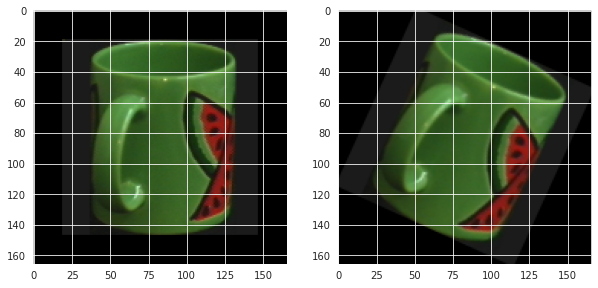

2022-08-18 19:40:51.280483: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [38]:
img_id = 51
for d, data in enumerate(dataset):
    image_vanilla = tf.cast(data['image'], tf.float32) / 255.
    image_rotated = tf.cast(data['rotated'], tf.float32) / 255.
    if d == img_id:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image_vanilla)
        ax[1].imshow(image_rotated)
        plt.show()
        break

### Plot the beams overlay

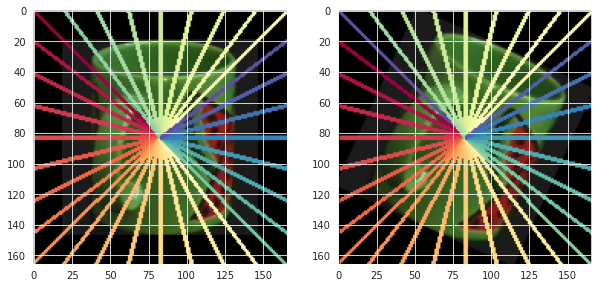

In [41]:
def img_color_beams(ax, image, lines, colors):
    image = np.array(image)
    for line, color in zip(lines, colors[:, :3] / 255):
        image[line[1, :, 0], line[1, :, 1]] = color
        image[line[0, :, 0], line[0, :, 1]] = color
        image[line[2, :, 0], line[2, :, 1]] = color
    ax.imshow(image)
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

# unique color codes for each beam
color_codes = np.array([matplotlib.cm.get_cmap('Spectral')(i, bytes=True)
                        for i in np.linspace(0, 1, n_beams)])
# circle color codes by rotation angle
colors = np.array([np.roll(color_codes, i, axis=0) for i in range(len(angles))])

# plot X0 and Xbeta with color beams as a sanity check
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = img_color_beams(ax[0], image_vanilla, lines, colors[0])
ax[1] = img_color_beams(ax[1], image_rotated, lines, colors[1])
plt.show()

### Store the dataset

In [42]:
splits = [0.8, 0.2, 0.0]

n_train = int(splits[0] * float(dataset.cardinality()))
n_val = int(splits[1] * float(dataset.cardinality()))
n_test = int(splits[2] * float(dataset.cardinality()))

train_dataset = dataset.take(n_train)
val_dataset = dataset.skip(n_train).take(n_val)
test_dataset = dataset.skip(n_train).skip(n_val).take(n_train)

tf.data.experimental.save(train_dataset, 'data/{}_train'.format(dataset_name))
tf.data.experimental.save(val_dataset, 'data/{}_val'.format(dataset_name))
tf.data.experimental.save(test_dataset, 'data/{}_test'.format(dataset_name))